In [28]:
# importing all necessary libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

In [29]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1


In [30]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1'):
    for filename in filenames:
     paths.append(os.path.join(dirname, filename))
     label=filename.split('_')[-1]
     label=label.split('.')[0]
     labels.append(label.lower())
    if len(paths) == 2800:
     break
print('Dataset is Loaded')

Dataset is Loaded


In [31]:
len(paths)

2800

In [32]:
paths[:5]

['/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_seize_neutral.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_perch_neutral.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_luck_neutral.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_book_neutral.wav',
 '/root/.cache/kagglehub/datasets/ejlok1/toronto-emotional-speech-set-tess/versions/1/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_neutral/OAF_keep_neutral.wav']

In [33]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

#print("Path to dataset files:", path)

In [34]:
labels[:5]

['neutral', 'neutral', 'neutral', 'neutral', 'neutral']

In [35]:

# creating a DataFrame with speech file paths and their corresponding labels
df=pd.DataFrame()
df['speech']=paths
df['labels']=labels
df.head()

,speech,labels
0,/root/.cache/kagglehub/datasets/ejlok1/toronto...,neutral
1,/root/.cache/kagglehub/datasets/ejlok1/toronto...,neutral
2,/root/.cache/kagglehub/datasets/ejlok1/toronto...,neutral
3,/root/.cache/kagglehub/datasets/ejlok1/toronto...,neutral
4,/root/.cache/kagglehub/datasets/ejlok1/toronto...,neutral


In [36]:
df['labels'].value_counts()  #we can see its balance dataset

,count
labels,
neutral,400
fear,400
disgust,400
sad,400
angry,400
ps,400
happy,400


<Axes: xlabel='labels', ylabel='count'>

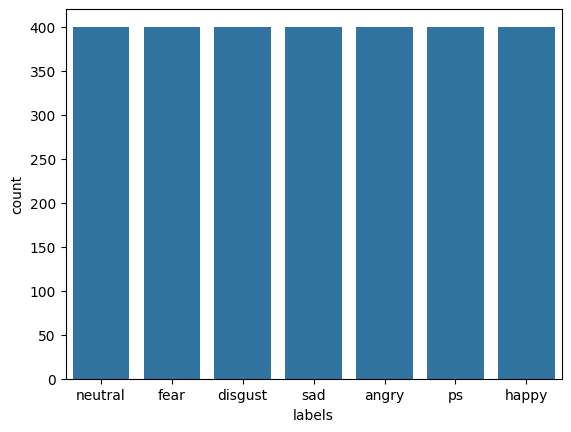

In [37]:

sns.countplot(data=df, x='labels')

In [38]:
# function to plot the waveform(loudness over time) of an audio signal
def waveplot(data, sr, emotion):
  plt.figure(figsize=(8,2))
  plt.title(emotion, size=20)
  librosa.display.waveshow(data, sr=sr) #displayinf waveplot using librosa
  plt.show()

In [39]:
# function to plot the spectogram(frequency spectrum) of an audio signal
def spectrogram(data, sr, emotion):
  x=librosa.stft(data)  # applying short-time fourier transform
  xdb=librosa.amplitude_to_db(abs(x)) #converting amplitude to decibels
  plt.figure(figsize=(8,2))
  plt.title(emotion, size=20)
  librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz') #displaying spectrogram
  plt.colorbar()

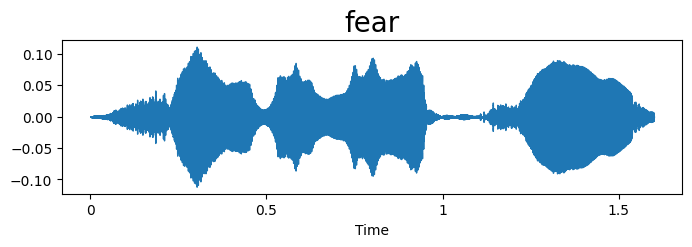

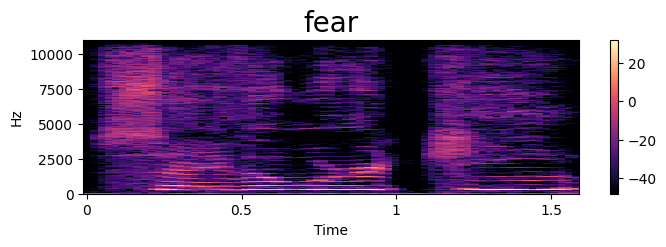

In [40]:
# example of waveplot and spectrogram for 'fear' emotion
emotion='fear'
path=np.array(df['speech'][df['labels']==emotion])[210]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

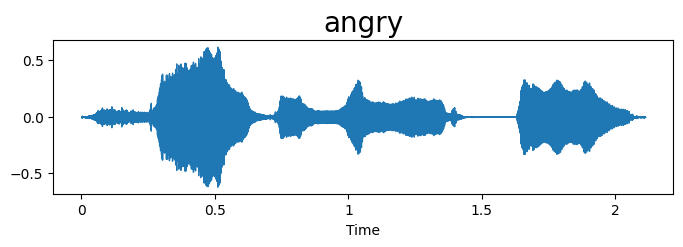

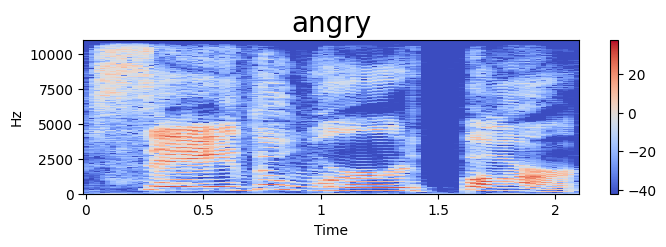

In [41]:
# example of waveplot and spectrogram for 'angry' emotion
emotion='angry'
path=np.array(df['speech'][df['labels']==emotion])[150]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

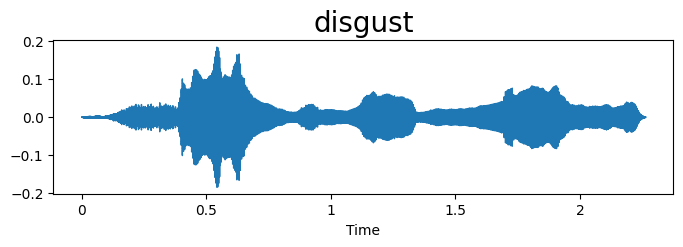

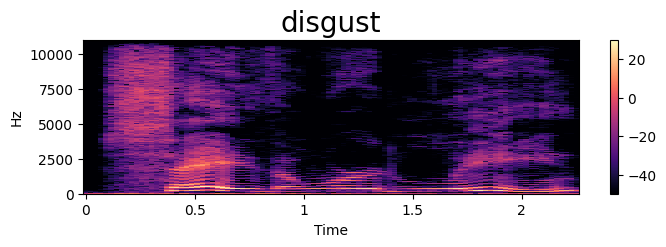

In [42]:
# example of waveplot and spectrogram for 'disgust' emotion
emotion='disgust'
path=np.array(df['speech'][df['labels']==emotion])[200]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

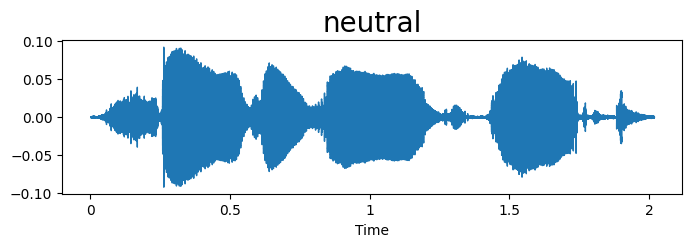

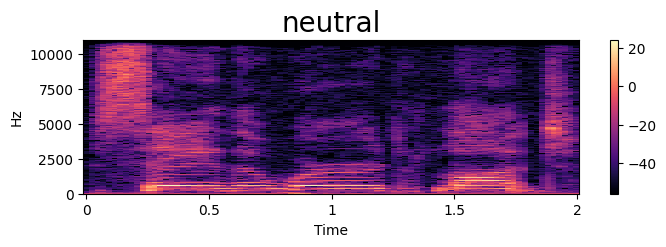

In [43]:
# example of waveplot and spectrogram for 'neutral' emotion
emotion='neutral'
path=np.array(df['speech'][df['labels']==emotion])[210]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

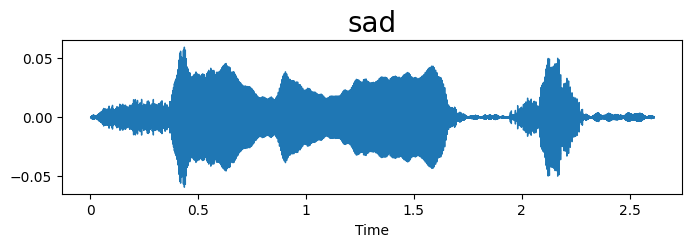

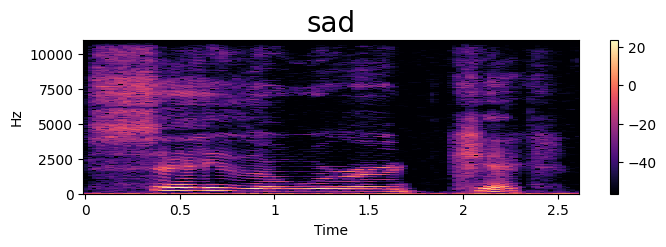

In [44]:
# example of waveplot and spectrogram for 'sad' emotion
emotion='sad'
path=np.array(df['speech'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

In [45]:
# Data Augmentation Functions Adding more variations to the training data(tech: time_stretch, pitch_shift, noise injection,)
def augument_audio(data, sr):
  # time stretching
  if np.random.random() < 0.5:
    data = librosa.effects.time_stretch(data, rate=np.random.uniform(0.8, 1.2))
  # noice injection
  if np.random.random() < 0.5:
    noice=np.random.randn(len(data))
    data = data + 0.005 * noice
  # time shifting
  if np.random.random() < 0.5:
    shift = np.random.randint(-sr // 10, sr // 10)
    data=np.roll(data, shift)
    if shift > 0:
      data[:shift] = 0
    else:
      data[shift:] = 0
  return data

In [46]:
#Feature Extraction
def extract_mfcc(filename, augument=False):
  y, sr = librosa.load(filename, duration=3, offset=0.5) # Load the audio file with a maximum duration of 3 seconds and an offset of 0.5 seconds.
  # If we want to apply audio augmentation (changing the audio slightly), do it here.
  if augument:
    y = augument_audio(y, sr)  # Call the augment_audio function to change the audio.

    # Check if the augmented audio data is a 1D array (like a single line of numbers).
    if y.ndim != 1:
      raise ValueError("Augument audio data is not a 1D array.") # Raise an error if the shape is wrong.

  # Extract the MFCC features from the audio. # MFCC (Mel-Frequency Cepstral Coefficients) are special features that help us understand the sound.
  mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)     # Calculate and average the MFCCs.

  return mfcc


In [47]:
extract_mfcc(df['speech'][0])

array([-5.1276697e+02,  5.1108181e+01,  3.0396475e+01,  2.0482607e+01,
        1.5544736e+01,  1.3279158e+01, -8.2306013e+00, -6.3109946e+00,
       -1.4839056e+01, -4.8939171e+00, -1.1697705e+01,  2.5777652e+00,
       -6.5463252e+00,  6.9426622e+00,  8.3371592e+00,  1.7436645e+00,
       -4.2938170e+00,  1.0086909e+01, -6.7106438e+00,  6.8047458e-01,
        2.2045543e+00,  6.8080205e-01,  2.9704013e-01,  1.5772874e+00,
       -9.3806496e+00,  5.1777446e-01, -7.3445711e+00, -1.3612508e+00,
       -4.7713857e+00,  1.7480114e+00, -4.7669396e+00, -3.1291940e+00,
       -8.3349218e+00,  1.7501868e+00,  7.6486540e+00,  1.9419672e+01,
        2.7820587e+01,  3.3503330e+01,  2.9371279e+01,  2.3630991e+01],
      dtype=float32)

In [48]:
# Now we extract features from all the audio in the 'speech' column of our DataFrame.
# We apply auguentation to some and keep the original audio for comparision
X_mfcc_augumented = df['speech'].apply(lambda x: extract_mfcc(x, augument=True))  # Extract features with audio changes.
X_mfcc_original = df['speech'].apply(lambda x: extract_mfcc(x, augument=False)) #Extract features without audio changes.

In [49]:
X_mfcc_augumented

,speech
0,"[-541.6677, 49.785202, 30.643747, 20.508408, 1..."
1,"[-585.5908, 93.805115, 20.59079, 0.6489989, 15..."
2,"[-534.8854, 118.42983, 28.258944, -3.8745155, ..."
3,"[-542.1101, 104.148705, 25.194147, -3.0870075,..."
4,"[-545.2414, 82.83507, 8.934241, 13.617003, 27...."
...,...
2795,"[-266.3876874629872, 28.259517685607157, 10.31..."
2796,"[-270.41251448443074, 39.25738279828493, 6.637..."
2797,"[-271.30532581079706, 33.3097173150147, 3.4594..."
2798,"[-462.66196, 108.09238, 1.7135373, -19.58866, ..."


In [50]:
X_mfcc_original

,speech
0,"[-512.76697, 51.10818, 30.396475, 20.482607, 1..."
1,"[-567.66705, 92.04904, 22.419819, 1.511591, 15..."
2,"[-534.8854, 118.42983, 28.258944, -3.8745155, ..."
3,"[-525.7402, 100.4599, 25.461254, -2.8482752, 4..."
4,"[-520.45776, 82.29463, 10.982734, 13.551876, 2..."
...,...
2795,"[-385.5105, 70.843056, 14.694961, -7.0393867, ..."
2796,"[-439.6358, 119.30593, 6.9817834, -28.531654, ..."
2797,"[-431.4915, 101.61931, -4.595464, -9.667319, 1..."
2798,"[-445.4041, 93.353004, 2.4792054, -16.53722, 0..."


In [51]:
X_mfcc_augumented.shape, X_mfcc_original.shape

((2800,), (2800,))

In [52]:
# Combine augmented and original MFCC features into one dataset.
# This helps us use both types of data (original and changed) for training our model.
X_combined = pd.concat([X_mfcc_augumented, X_mfcc_original], axis=0)
X = np.array([x for x in X_combined]) # Convert the combined features into a NumPy array for easier processing.
X = np.expand_dims(X, -1)  # Add an extra dimension to make the shape compatible with the LSTM model.
X.shape


(5600, 40, 1)

In [53]:
# Combine original and augmented labels & Encoding the labels (emotion classes) into one-hot encoded format
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_combined = pd.concat([df['labels'],df['labels']], axis=0).to_numpy() # converting to numpy array
y = enc.fit_transform(y_combined[:, np.newaxis]).toarray()
y, y.shape

(array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 (5600, 7))

In [57]:
#Building LSTM model for speech Emotion Recognition
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#Build the LSTM model using a sequential approach, layer by layer
model = Sequential([
                    LSTM(256, return_sequences=False, input_shape=(40,1)),
                    # First LSTM layer with 256 units (neurons)

                    # First dense (fully connected) layer with 128 units and ReLU activation function.
                    # ReLU helps the model learn complex patterns by allowing it to output zero for negative inputs.
                    Dense(128, activation='relu'),

                    # Second dense layer with 64 units and ReLU activation.
                    Dense(64, activation='relu'),

                    # Third dense layer with 64 units and ReLU activation.
                    Dense(64, activation='relu'),

                    # Dropout layer to prevent overfitting by randomly setting 20% of the neurons to zero during training.
                    Dropout(0.2),

                    # Fourth dense layer with 32 units and Relu activation.
                    Dense(32, activation='relu'),

                    # Another dropout layer to further help with regularization, reducing overfitting.
                    Dropout(0.1),

                    # Final output layer with 7 units and softmax activation function.
                    # Softmax converts the output to probabilities for 7 emotion classes (e.g., happy, sad, angry).
                    Dense(7, activation='softmax')

                    ])
# Compile the model by specifying the loss function, optimizer, and metrics to track.
# 'categorical_crossentropy' is used for multi-class classification problems.
# 'adam' is a popular optimizer that adjusts the learning rate during training.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
# Display a summary of the model's architecture, including the number of parameters.
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 311,815 (1.19 MB)

 Trainable params: 311,815 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
from keras.callbacks import ModelCheckpoint, EarlyStopping #Import tools to control model training and save progress.

checkpoint = ModelCheckpoint("mymodel.keras", monitor='val_accuracy', verbose=1,save_weights_only=False )

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64, validation_steps=5, callbacks=[checkpoint, early])

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4629 - loss: 1.3747
Epoch 1: saving model to mymodel.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.4650 - loss: 1.3695 - val_accuracy: 0.3750 - val_loss: 1.0493
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7931 - loss: 0.5391
Epoch 2: saving model to mymodel.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.7936 - loss: 0.5380 - val_accuracy: 0.5750 - val_loss: 1.3919
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8965 - loss: 0.3324
Epoch 3: saving model to mymodel.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.8967 - loss: 0.3319 - val_accuracy: 0.9469 - val_loss: 0.1270
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9320 - loss: 0.2322
Epoch 4: saving model to mymodel.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 586ms/step - accuracy: 0.9320 - loss: 0.2323 - val_accuracy: 0.9062 - val_loss: 0.2561
Epoch 5/50
70/70 ━━━━━━━━━━━

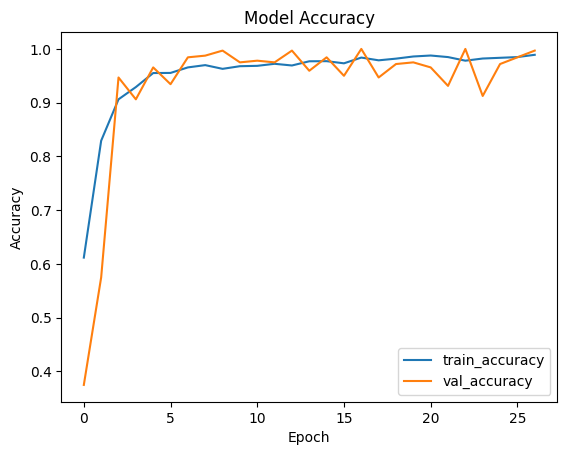

In [61]:
#plotting the training and validation accuracy across epochs
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

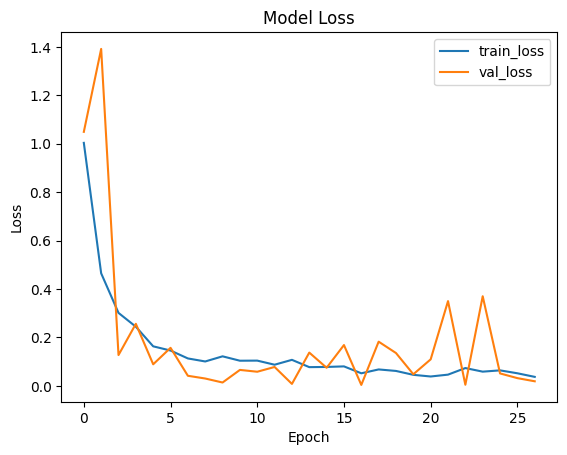

In [62]:
# Plotting the training and validation loss across epochs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()